# Predicting First Impressions Using Hierarchical Machine Learning



In [1]:
the_answer_to_life_the_universe_and_everything = 42

import pandas as pd
import numpy as np
import skimage
import sklearn
import matplotlib.pyplot as plt
from matplotlib import cm

rng = np.random.default_rng(seed=the_answer_to_life_the_universe_and_everything)

# Predicting First Impressions

When a person first sees someone, they will typically form some judgement of that person characteristics.
Modelling that judgement is the goal of this study.
The paper, *Predicting First Impressions with Deep Learning* provides a dataset of around 6000 images which are annotated with four attributes; Age, IQ, Dominance and Trustworthiness.
The authors of the original paper compared the results of several standard CNN's at the task (Basic6, VGG16, VGG19, Shallow, etc.).
The approach taken in this study is to apply the foundational machine learning methods learned in CS345 in an attempt to equal or better the accuracy of the original papers authors.

Our approach will be to first load the annotated data and use some basic machine learning and statistical methods to understand it.
Given the insight gained by making observations of the data, we will then try to identify two potential strategies to perform the task.
Finally, we will implement and compare the two strategies and discuss their performance.

We expect the results to be pitifully bad.
Like horribly bad.
Like, it might be publishable just how poorly these results are going to be.
But what is most interesting in this study is the attempt to apply the ML strategies learned in class to a new problem that is beyond their capabilities.

# Load data

The raw structure of the data we care about is:

- Images are in the Images directory: 'Images/*.jpg'
- Annotations are in the Annotations directory: 'Annotations/[Age, Dominance, IQ, Trustworthiness]/annotations.csv'

In [2]:
def load_images():
    import os
    from skimage import io
    img_names = os.listdir('./Images')
    data_dir = os.path.join(os.getcwd(), 'Images')
    X = []
    for img in img_names:
        img_path = os.path.join(data_dir, img)
        X.append(io.imread(img_path))
    
    print(f'Loaded {len(X)} images...')
    
    return np.asarray(X), img_names

# X, img_names = load_images()

In [3]:
def load_annotations(img_names):
    import os
    annotation_types = os.listdir('./Annotations')
    data_dir = os.path.join(os.getcwd(), 'Annotations')
    data_frames = []
    for annotation in annotation_types:
        annotation_path = os.path.join(data_dir, annotation, 'annotations.csv')
        csv = pd.read_csv(annotation_path)
        csv = csv.rename(columns={csv.columns[0]: "Image"})
        data_frames.append(csv)
    
    data_frame = data_frames[0]
    for i in range(1, len(data_frames)):
        data_frame = pd.merge(data_frame, data_frames[i], how='outer')
    
    print(f'The annotations reference {data_frame.shape[0]} images...')

    return data_frame, annotation_types

# annotations, annotation_types = load_annotations(img_names)

In [4]:
def load_cleaned_data():
    """There are images listed in the annotations that don't exist.
    So let's get rid of them and return a clean dataset."""
    X, img_names = load_images()
    annotations, annotation_types = load_annotations(img_names)
    annotations = annotations.dropna()
    mask = np.isin(img_names, annotations['Image'])

    print(f'We are deleting {len(mask) - np.sum(mask)} images...')
    print(f'Leaving a total of {np.sum(mask)} images...')

    return X[mask], np.asarray(annotations[annotation_types]), annotation_types

### Loading and Cleaning the data...

There are images referenced in the annotations that don't exist.
I'm simply ignoring those annotations.

There are also images that are missing one or more annotation.
I'm simply ignoring those images.

I unfortunately cannot verify that the data was correctly annotated.
But this was good enough to publish so it's good enough for me.

In [5]:
X, y, annotation_labels = load_cleaned_data()
n = X.shape[0]

Loaded 6300 images...
The annotations reference 6420 images...
We are deleting 289 images...
Leaving a total of 6011 images...


In [6]:
print(n)
print(X.shape)
print(y.shape)

6011
(6011, 150, 130)
(6011, 4)


# Understand my Data

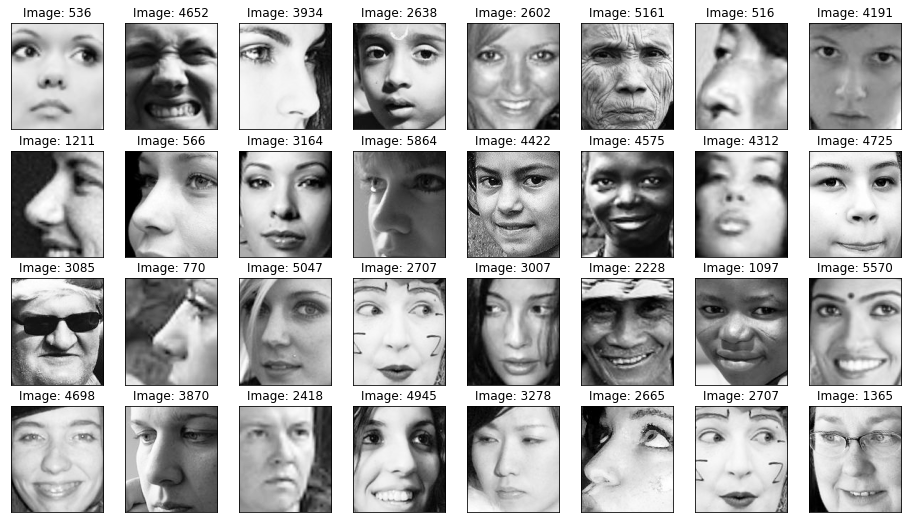

In [7]:
def plot_samples(nrows=4, ncols=8, figsize=(16,9), rseed=None):
    rng = np.random.default_rng(seed=rseed)

    num_choices = nrows*ncols
    choices = rng.choice(n, size=num_choices)
    the_chosen = X[choices]

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
        subplot_kw={'xticks': [], 'yticks': []},
        figsize=(16,9))
    for i, ax in zip(range(num_choices), axs.flat):
        ax.imshow(the_chosen[i], cmap=cm.Greys_r)
        ax.set_title(f'Image: {choices[i]}')

    plt.show()

plot_samples(rseed=42)

### Observations

- The gray values go from [0, 255] == [white, black]
- Not all faces are 'frontalized'.
- This sample appears to be dominated by light skinned people.
- Position of the eyes, nose and mouth appear to be mostly equal.
- It looks like there are more people looking to the left than the right?  About 5 right, 10 left in this sample.

In [8]:
print(f'Mean pixel value: {np.mean(X):.3f}')
print(f'Median pixel value: {np.median(X):.3f}')
print(f'Standard Deviation of pixel value: {np.std(X):.3f}')
print(f'95% of pixel values fall within the range: [{np.mean(X) - np.std(X):.3f}, {np.mean(X) + np.std(X):.3f}]')

Mean pixel value: 138.867
Median pixel value: 146.000
Standard Deviation of pixel value: 64.513
95% of pixel values fall within the range: [74.354, 203.379]


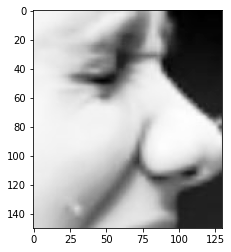

In [9]:
# Degenerate images???
degeneracies = [243, 5926, 2243]

plt.imshow(X[degeneracies[2]], cmap=cm.Greys_r)

# Visualizing statistics

No real goal here other than to see what else might be significant in the data.
Just exploring.

52.3190816835801
179.70537348194975


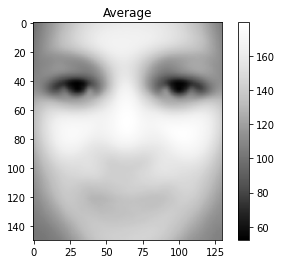

In [10]:
average_image = np.mean(X, axis=0)
print(np.min(average_image))
print(np.max(average_image))
plt.imshow(average_image, cmap = cm.Greys_r)
plt.title('Average')
plt.colorbar()
plt.show()

35.0
189.0


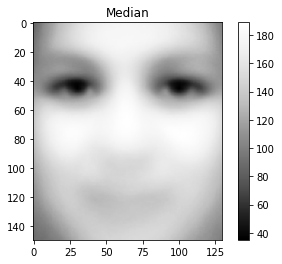

In [11]:
median_image = np.median(X, axis=0)
print(np.min(median_image))
print(np.max(median_image))
plt.imshow(median_image, cmap = cm.Greys_r)
plt.title('Median')
plt.colorbar()
plt.show()

48.89262927543408
77.66436171637174


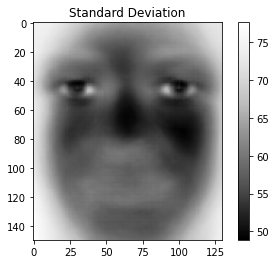

In [12]:
std_image = np.std(X, axis=0)
print(np.min(std_image))
print(np.max(std_image))
plt.imshow(std_image, cmap = cm.Greys_r)
plt.title('Standard Deviation')
plt.colorbar()
plt.show()

156.0
245.0


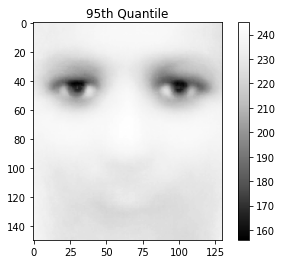

In [13]:
quantile_image = np.quantile(X, 0.95, axis=0)
print(np.min(quantile_image))
print(np.max(quantile_image))
plt.imshow(quantile_image, cmap=cm.Greys_r)
plt.title('95th Quantile')
plt.colorbar()
plt.show()

0.0
45.0


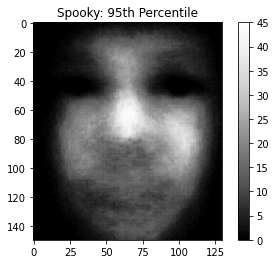

In [14]:
percentile_image = np.percentile(X, 0.95, axis=0)
print(np.min(percentile_image))
print(np.max(percentile_image))
plt.imshow(percentile_image, cmap=cm.Greys_r)
plt.title('Spooky: 95th Percentile')
plt.colorbar()
plt.show()

### Observations

- The standard deviation indicates there is a lower variance in the values of the nose and the left cheeks of the subjects (right side of the image).
- All three 'statistical' images indicate that the majority of the dataset is composed of 'frontalized' faces.
- The majority of the variance in the data is in on the borders of the images.

# What is the distribution of the attributes???

Per the paper, 'Predicting First Impressions with Deep Learning':
- Data was collected using a mechanical turk: *TestMyBrain.org*
- Each attribute was rated using a Likert scale numbers 1-7
- Trustworthiness and Dominance are the average of about 32 judgements on each image
- Trustworthiness and Dominance were both normalized
- Age and IQ are the average of about 15 judgements on each image

In [15]:
def plot_attribute_data(y, name, nbins=200):
    bounds = [np.min(y), np.max(y)]
    mu = np.mean(y)
    sigma = np.std(y)

    counts, vals = np.histogram(y, bins=nbins)
    largest_bin = np.argmax(counts)

    print(f'Statistics for attribute: {name}')
    print(f'min: {bounds[0]:.4f}, max: {bounds[1]:.4f}')
    print(f'mean: {mu:.4f}')
    print(f'std: {sigma:.4f}')
    print(f'The largest bin is of size {counts[largest_bin]} at {vals[largest_bin]}')

    plt.hist(y, bins=nbins)

Statistics for attribute: Dominance
min: 0.0625, max: 0.8750
mean: 0.4495
std: 0.1309
The largest bin is of size 98 at 0.4890625


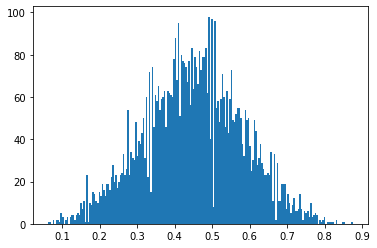

In [16]:
plot_attribute_data(y[:,0], annotation_labels[0])
plt.show()

Statistics for attribute: Trustworthiness
min: 0.0278, max: 0.8258
mean: 0.4334
std: 0.1236
The largest bin is of size 112 at 0.33101027600000005


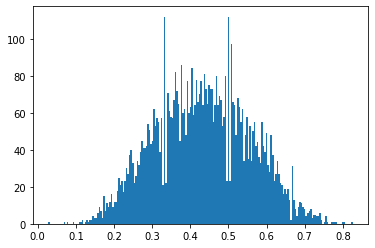

In [17]:
plot_attribute_data(y[:,1], annotation_labels[1])
plt.show()

Statistics for attribute: IQ
min: 1.7273, max: 6.2000
mean: 3.9860
std: 0.5852
The largest bin is of size 270 at 3.985999999865


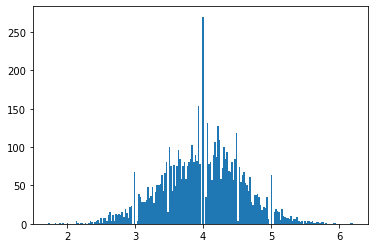

In [18]:
plot_attribute_data(y[:,2], annotation_labels[2])
plt.show()

Statistics for attribute: Age
min: 1.0000, max: 6.9565
mean: 3.5095
std: 1.2011
The largest bin is of size 160 at 2.995434782565


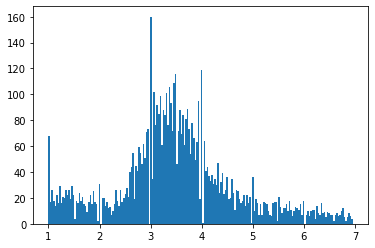

In [19]:
plot_attribute_data(y[:,3], annotation_labels[3])
plt.show()

# Observations

- It would be nice have truth values for Age and IQ.  That is not possible with Dominance or Trustworthiness.
- None of my statistics match that reported in the paper.  This may be because I removed images that do not have all 4 attributes.
- Trustworthiness, IQ and Age have some significant 'spikes' in the bin counts.

## Dominance and Trustworthiness

- The image ratings for both attributes appear to be normally distributed with means slightly below $1/2$.
- Neither attribute has a min of 0.0 or a max of 1.0.  This is possible if and only if not a single image was ever scored all 1's or all 7's for either attribute.

## IQ

- Appears normally distributed
- There is a significant spike 

## Age

- Approximately left leaning normal with a significant shoulder at 1

## Where are our Principal Components?

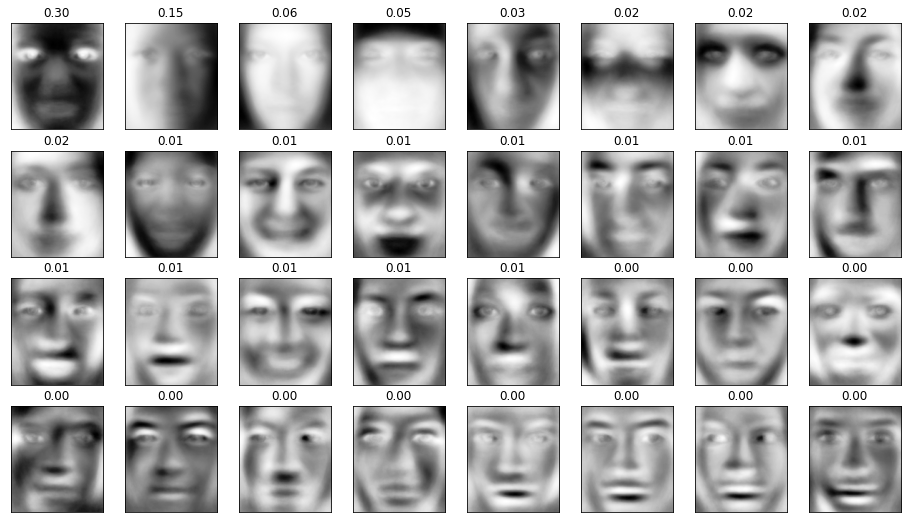

In [20]:
from sklearn.decomposition import PCA

# WARNING: This takes about 3 minutes on my laptop
# So only do it once
if 'pca' not in locals():
    pca = PCA()
    pca.fit(X.reshape((X.shape[0], X.shape[1]*X.shape[2])))

img_shape = (X.shape[1], X.shape[2])

def plot_pca_components(nrows=4, ncols=8, figsize=(16,9)):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
        subplot_kw={'xticks': [], 'yticks': []},
        figsize=(16,9))
    fig.set_facecolor('w')
    for i, ax in zip(range(nrows*ncols), axs.flat):
        ax.imshow(pca.components_[i].reshape(img_shape), cmap=cm.Greys_r)
        ax.set_title(f'{pca.explained_variance_ratio_[i]:.2f}')

    plt.show()

plot_pca_components()

# Are there pixels that have high correlation with any of the attributes?

Is that cheating if I find one? :P

In [21]:
def compute_pixel_correlation(X, y):
    X_flat = X.reshape((X.shape[0], X.shape[1]*X.shape[2]))
    pixel_indices = np.arange(0, X_flat.shape[1])
    corr = [np.corrcoef(X_flat[:,i], y)[0,1] for i in pixel_indices]
    return np.array(corr).reshape(X.shape[1:])

def plot_correlation_image(img, label):
    """We don't care if the correlation is positive or negative,
    so we are plotting the absolute correlation."""
    abs_img = np.abs(img)
    plt.imshow(abs_img, cmap=cm.hot)
    plt.title(f'Pixelwise Correlation with: {label}')
    plt.colorbar()

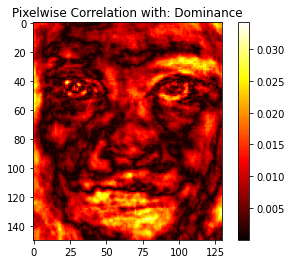

In [22]:
corr = compute_pixel_correlation(X, y[:,0])
plot_correlation_image(corr, annotation_labels[0])

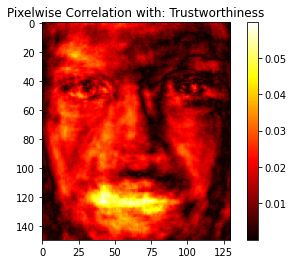

In [23]:
corr = compute_pixel_correlation(X, y[:,1])
plot_correlation_image(corr, annotation_labels[1])

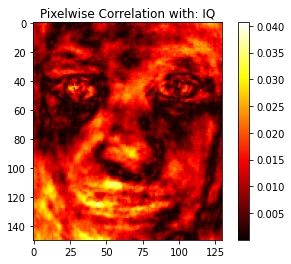

In [24]:
corr = compute_pixel_correlation(X, y[:,2])
plot_correlation_image(corr, annotation_labels[2])

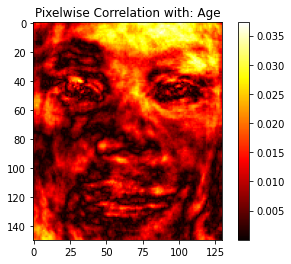

In [25]:
corr = compute_pixel_correlation(X, y[:,3])
plot_correlation_image(corr, annotation_labels[3])

# Observations

OK.  Not really a surprise here.

- There is basically no correlation with the maximum absolute correlation being around 0.06.
- It does indicate that there are regions in the images that appear to have higher correlation (e.g. the forehead for Age and mouth for Trustworthiness).  But the correlation is so low that who cares???

# What if we look at the projection of each image on the principal components to see if any of them have high correlation?

In [26]:
def cos_dist(X, y):
    X_flat = X.reshape((X.shape[0], X.shape[1]*X.shape[2]))
    cd = [np.dot(y, X_flat[i]) for i in range(X.shape[0])]
    return np.array(cd)

def compute_pca_component_correlation(X, y, component):
    cd = cos_dist(X, component)
    return np.corrcoef(cd, y)[0,1]

In [27]:
# WARNING: This took 2 minutes on my computer...

if 'component_corrs' not in locals():
    component_corrs = np.array([
        [compute_pca_component_correlation(X, y[:,i], pca.components_[j])
            for i in range(4)]
                for j in range(100)
    ])

In [28]:
print("OH NO!  We have pixels with higher correlation than the top 100 principal components.... LOLOL\nThis is not going to work.\n")
# print(f'{np.max(np.abs(component_corrs)):.3}')

print(f'Corellation between PCA components and {annotation_labels[0]}: {np.max(np.abs(component_corrs[:,0])):.3}')
print(f'Corellation between PCA components and {annotation_labels[1]}: {np.max(np.abs(component_corrs[:,1])):.3}')
print(f'Corellation between PCA components and {annotation_labels[2]}: {np.max(np.abs(component_corrs[:,2])):.3}')
print(f'Corellation between PCA components and {annotation_labels[3]}: {np.max(np.abs(component_corrs[:,3])):.3}')

OH NO!  We have pixels with higher correlation than the top 100 principal components.... LOLOL
This is not going to work.

Corellation between PCA components and Dominance: 0.0319
Corellation between PCA components and Trustworthiness: 0.0405
Corellation between PCA components and IQ: 0.0389
Corellation between PCA components and Age: 0.0288


# Machine Learning - What Algorithms Will I Use?

My hypothesis is the data is probably too complicated to be effectively modeled using the foundational algorithms that we used in class.
I think that there are spatially related features that are probably the best descriptors that we don't have the tools for yet.
Since we are explicitly avoiding the use of deep learning, the benefits of the feature extraction learned by convultional networks is strictly not allowed.
However, what can we do with our limited resources?
We have already performed dimensionality reduction using PCA.
What are our options for regression given the first 100 principal components?

- linear/ridge/lasso regression
- nearest neighbors regression
- decision tree regression
- polynomial regression
- random forest

So I will try ~~**Linear Regression** and **Polynomial Basis Regression**~~ everything I can to specifically satisfy the assignment.
After the conclusion, if I still have the energy, I will add the rest of the regressors and will also look at using a random forest.

I will also only be performing regression on a single attribute of the data.
Namely, 'Trustworthiness'.
I chose this attribute because the top 100 components had the highest correlation with 'Trustworthiness' vs the other attributes.

## Known issues with this strategy

I am working with the top 100 principal components.
These are the components with the highest explained variance and are best able to describe the images.
However, that does not indicate that they describe the features in the dataset that can be used effectively for regression.
Looking at the top 100 components was just an arbitrary decision due to how long training took.

## Get the Input Data Ready

For all images, project them onto the top 100 principal components.
Store those values into X_pc.
Save the 'Trustworthiness' target values as y_pc.

Create a train/test split of ~~0.6/0.4~~ 0.8/0.2.

In [29]:
assert annotation_labels[1] == 'Trustworthiness'

y_pca = y[:,1]

X_pca = np.array([
    [ cos_dist(np.asarray([X[i]]), pca.components_[j]) for j in range(100)]
        for i in range(X.shape[0])
])

In [30]:
# check if sorted
is_sorted = np.all(pca.explained_variance_ratio_[:-1] <= pca.explained_variance_ratio_[:1])
print(f'Principal components are sorted: {is_sorted}')

print(f'There are a total of {pca.explained_variance_ratio_.shape[0]} components.')
print(f'We are going to look at the top 100 which is only the top {100/pca.explained_variance_ratio_.shape[0]:.3}% of the components.')
print(f'The explained variance ratio of the top 100 components is {np.sum(pca.explained_variance_ratio_[:100]):.3}')

print('\nAs I mentioned in the "Machine Learning Approaches" section, variance does not indicate feature quality.')

Principal components are sorted: True
There are a total of 6011 components.
We are going to look at the top 100 which is only the top 0.0166% of the components.
The explained variance ratio of the top 100 components is 0.906

As I mentioned in the "Machine Learning Approaches" section, variance does not indicate feature quality.


In [31]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_pca, y_pca, test_size = 0.2, random_state=the_answer_to_life_the_universe_and_everything)

print('train')
print(X_train.shape)
print(y_train.shape)
print('\ntest')
print(X_test.shape)
print(y_test.shape)

train
(4808, 100, 1)
(4808,)

test
(1203, 100, 1)
(1203,)


=====
# Get statistics ready
=====

In [50]:
def prep_model_stats(y_pred, y_test):
    print(f'Predicted: Min {np.min(y_pred):.3}, Max {np.max(y_pred):.3}')
    print(f'Target   : Min {np.min(y_test):.3}, Max {np.max(y_test):.3}')
    print()
    print(f'Predicted std: {np.std(y_pred):.3}')
    print(f'Target    std: {np.std(y_test):.3}')
    print()

    error = y_pred-y_test
    mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
    mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    r2 = sklearn.metrics.r2_score(y_test, y_pred)

    print(f'STD of the error: {np.std(error):.3}')
    print(f'MAE: {mae:.3}')
    print(f'RMSE: {mse:.3}')
    print(f'R2: {r2:.3}')

    return {
        'error': error,
        'mae': mae,
        'mse': mse,
        'r2': r2
    }

=====
# Linear Regression
=====

In [55]:
# Train and Predict

lr = sklearn.linear_model.LinearRegression()
lr.fit(X_train.squeeze(), y_train)
y_pred = lr.predict(X_test.squeeze())

error = y_pred-y_test

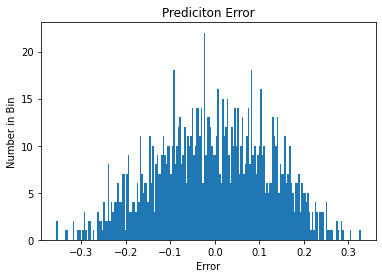

In [56]:
plt.hist(error, bins=200)
plt.title('Prediciton Error')
plt.xlabel('Error')
plt.ylabel('Number in Bin')
plt.show()

In [57]:
lr_stats = prep_model_stats(y_pred, y_test)

Predicted: Min 0.355, Max 0.52
Target   : Min 0.119, Max 0.804

Predicted std: 0.0198
Target    std: 0.126

STD of the error: 0.127
MAE: 0.105
RMSE: 0.0163
R2: -0.0281


=====
# Polynomial Basis Regression
=====

## Nevermind

My laptop doesn't have the resources to do this on an 80/20 split.

In [58]:
# from sklearn.pipeline import Pipeline


# # WARNING: Maxed out my 8-core laptop with 16GB
# degree = 3

# pipe = Pipeline([
#     ('polynomial basis', sklearn.preprocessing.PolynomialFeatures(degree=degree)),
#     ('linear regression', sklearn.linear_model.LinearRegression())
# ])
# pipe.fit(X_train.squeeze(), y_train)

In [59]:
# y_pred = pipe.predict(X_test.squeeze())
# error = y_pred-y_test


In [60]:
# plt.hist(error, bins=200)
# plt.title('Prediciton Error')
# plt.xlabel('Error')
# plt.ylabel('Number in Bin')
# plt.show()

In [61]:
# print(f'Predicted: Min {np.min(y_pred):.3}, Max {np.max(y_pred):.3}')
# print(f'Target   : Min {np.min(y_test):.3}, Max {np.max(y_test):.3}')
# print()
# print(f'Predicted std: {np.std(y_pred):.3}')
# print(f'Target    std: {np.std(y_test):.3}')
# print()
# print(f'STD of the error: {np.std(y_pred-y_test):.3}')
# print(f'MAE: {sklearn.metrics.mean_absolute_error(y_test, y_pred):.3}')
# print(f'RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred)):.3}')

=====
# Nearest Neighbors
=====

OK, polynomial regression is really bad.  Let's try nearest neighbors real quick.

In [62]:
from sklearn.neighbors import KNeighborsRegressor

neighbors = 5

nnr = KNeighborsRegressor(n_neighbors=neighbors)
nnr.fit(X_train.squeeze(), y_train)
y_pred = nnr.predict(X_test.squeeze())
error = y_pred - y_test

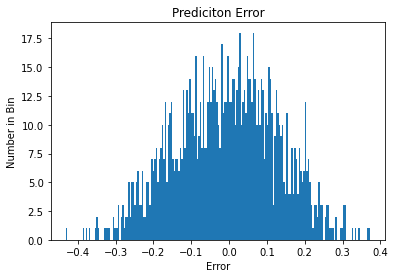

In [63]:
plt.hist(error, bins=200)
plt.title('Prediciton Error')
plt.xlabel('Error')
plt.ylabel('Number in Bin')
plt.show()

In [64]:
nnr_stats = prep_model_stats(y_pred, y_test)

Predicted: Min 0.234, Max 0.59
Target   : Min 0.119, Max 0.804

Predicted std: 0.0548
Target    std: 0.126

STD of the error: 0.136
MAE: 0.111
RMSE: 0.0187
R2: -0.179


====
Decision Tree Regressor
====

Well, nothing is going to be good.  Let's throw a bigger kitchen sink.

In [79]:
from sklearn.tree import DecisionTreeRegressor

depth = 3

dtr = DecisionTreeRegressor(criterion='poisson', max_depth=depth)
dtr.fit(X_train.squeeze(), y_train)
y_pred = dtr.predict(X_test.squeeze())
error = y_pred - y_test

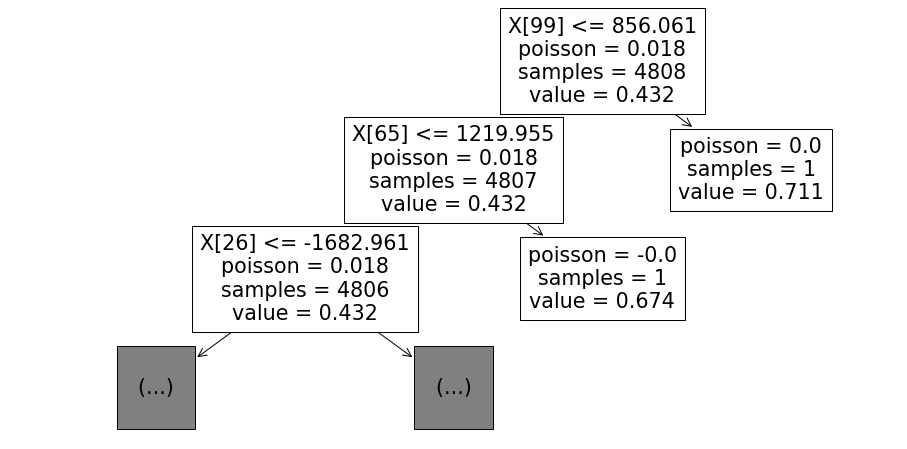

In [80]:
plt.figure(figsize=(16,8))
sklearn.tree.plot_tree(dtr, max_depth=2)
plt.show()

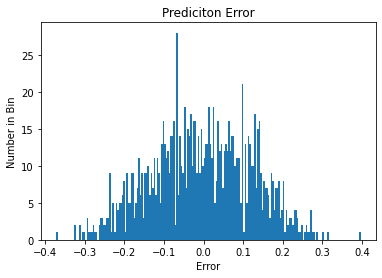

In [81]:
plt.hist(error, bins=200)
plt.title('Prediciton Error')
plt.xlabel('Error')
plt.ylabel('Number in Bin')
plt.show()

In [82]:
dtr_stats = prep_model_stats(y_pred,y_test)

Predicted: Min 0.432, Max 0.711
Target   : Min 0.119, Max 0.804

Predicted std: 0.0124
Target    std: 0.126

STD of the error: 0.126
MAE: 0.104
RMSE: 0.0159
R2: -0.00637


In [69]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train.squeeze(), y_train)
y_pred = rfr.predict(X_test.squeeze())
error = y_pred - y_test

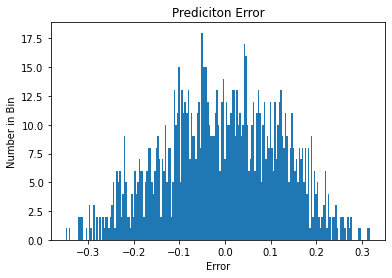

In [70]:
plt.hist(error, bins=200)
plt.title('Prediciton Error')
plt.xlabel('Error')
plt.ylabel('Number in Bin')
plt.show()

In [71]:
rfr_stats = prep_model_stats(y_pred, y_test)

Predicted: Min 0.382, Max 0.506
Target   : Min 0.119, Max 0.804

Predicted std: 0.0165
Target    std: 0.126

STD of the error: 0.127
MAE: 0.105
RMSE: 0.0162
R2: -0.0263


=====
# Plot Model Quality Statistics
=====

In [136]:
stats = {
    'lr': lr_stats,
    'nnr': nnr_stats,
    'dtr': dtr_stats,
    'rfr': rfr_stats
}

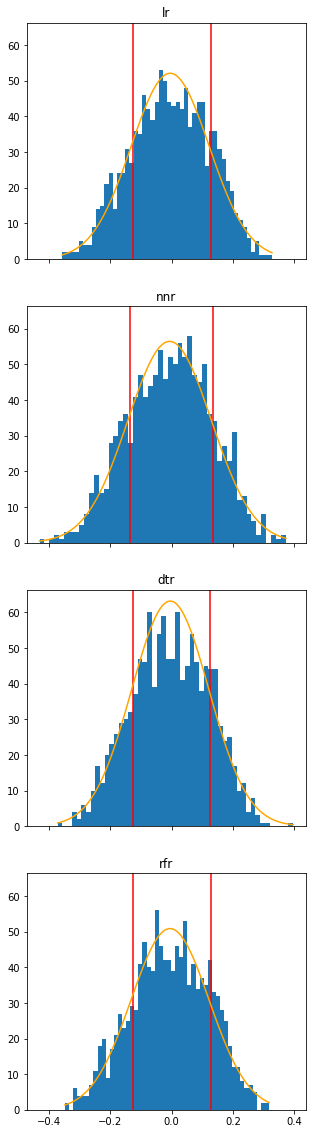

In [139]:
fig, axs = plt.subplots(len(stats.keys()), figsize=(5, 5*len(stats.keys())), sharex=True, sharey=True)
for i, key in zip(range(len(stats.keys())), stats.keys()):
    def normal_pdf(x, mu, sigma):
        frac = 1/(np.sqrt(2*np.pi)*sigma)
        expo = np.exp(
            (-(x-mu)**2) / (2*(sigma**2))
        )
        return frac*expo

    error = stats[key]['error']
    std = np.std(stats[key]['error'])

    axs[i].set_title(key)
    hists, _, _ = axs[i].hist(stats[key]['error'], bins=50)
    axs[i].axvline(-std, color='red')
    axs[i].axvline(std, color='red')

    ls = np.linspace(np.min(error), np.max(error), 100)
    # This does not fit the data correctly (I forgot the math) but close enough
    norm = normal_pdf(ls, np.mean(error), std) * np.std(hists)
    axs[i].plot(ls, norm, color='orange')

# plt.legend(legend)
plt.show()

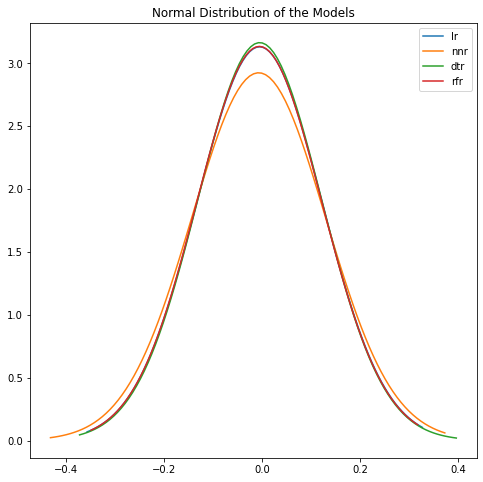

In [138]:
def normal_pdf(x, mu, sigma):
    frac = 1/(np.sqrt(2*np.pi)*sigma)
    expo = np.exp(
        (-(x-mu)**2) / (2*(sigma**2))
    )
    return frac*expo


legend = []
fig = plt.figure(figsize=(8,8))
for i, key in zip(range(len(stats.keys())), stats.keys()):
    legend.append(key)
    error = stats[key]['error']
    std = np.std(error)
    
    ls = np.linspace(np.min(error), np.max(error), 100)
    norm = normal_pdf(ls, np.mean(error), std)
    plt.plot(ls, norm)

plt.title('Normal Distribution of the Models')
plt.legend(legend)
plt.show()
    

In [137]:
df_stats = pd.DataFrame(stats)
df_stats.style

,lr,nnr,dtr,rfr
error,[ 0.1958754 -0.20316424 0.19501433 ... -0.20275931 -0.11284564 -0.01658345],[ 0.1374588 -0.1668406 0.2546546 ... -0.205141 -0.1694746 0.0234652],[ 0.19742058 -0.21092342 0.18226858 ... -0.20106442 -0.09714342 -0.02328742],[ 0.19459938 -0.19605468 0.18868721 ... -0.21502039 -0.10369736 -0.0179866 ]
mae,0.105060,0.111374,0.104054,0.104834
mse,0.016262,0.018657,0.015919,0.016235
r2,-0.028079,-0.179484,-0.006367,-0.026330


# Performance Summary

Frankly, I have no idea what any of those numbers mean.
So everything that follows is stuff that I made up to try to act like I know what is going on.

None of the models had a positive $r^2$ indicating that their performance was worse than a horizontal line.
The only model that outperformed any of the others was nearest neighbors regression.
But it outperformed the other models by consistently performing worse.
To claim that the variance in the mean absolute error or the mean squared error of the four models is significant would have you laughed out of a conference.

# Conclusion

Do not use these models.
Do use them to feed an ensamble algorithm either.
You are better of with a horizontal line regressor.

The significant advantages of image related machine learning tasks afforded by alexnet or resnet or other more recent neural networks is obvious.
It is extremely difficult to perform vision tasks using the basic machine learning models.
While the performance of the models explored in this study might be improved by searching for sobel filters, by using histogram of gradients or manifold learning, the task becomes almost (or maybe entirely) intractible as additional options are weighed.
The idea that a human researcher might be able to outperform a haphazardly copy pasted CNN when that researcher is restricted to traditional meachine learning is laughable.

This particular machine learning problem becomes even more difficult if you consider that there is no actual truth value.
Think about it, when you look at a persons face and judge just how trustworthy they are, how many other people make the exact same judgement that you made?
How many of them have had the same life experiences as you with people who have comparable facial features?
The answer is none.

How does a machine learning model predict the average human sentiment?